<a href="https://colab.research.google.com/github/Uemerson/xgboost-data-h-m1-challenge/blob/master/xgboost_data_h_m1_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dataset from Kaggle

Please follow the steps below to download and use kaggle data within Google Colab:

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. Go to your Google Colab project file and run the following commands:

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uemersonpinheiro","key":"d8f3eeeb7f9c1db56af4eeaace8a4ce4"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle competitions download -c data-h-m1-challenge-final
!unzip data-h-m1-challenge-final.zip

ref                                                                       title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/piterfm/2022-ukraine-russian-war                                 2022 Ukraine Russia War                              1KB  2022-03-27 14:28:52           3033        206  1.0              
datasets/prasertk/healthy-lifestyle-cities-report-2021                    Healthy Lifestyle Cities Report 2021                 2KB  2022-03-03 00:26:02           3096         97  1.0              
datasets/kamilpytlak/personal-key-indicators-of-heart-disease             Personal Key Indicators of Heart Disease             3MB  2022-02-16 10:18:03           5033        102  1.0              
datasets/vivek4

#Import necessary libs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
import time
import sklearn.metrics as metrics
from xgboost import XGBRegressor, DMatrix, cv
from xgboost import cv
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold, RepeatedKFold

# Connect with google drive

In [ ]:
# mount drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load datasets

In [ ]:
# import required libraries
import pandas as pd

submission_sample = pd.read_csv("submission_sample.csv")
sales = pd.read_csv("sales.csv")
meta_item = pd.read_csv("meta-item.csv")
meta_store = pd.read_csv("meta-store.csv")

In [ ]:
# Includes sales information
# DATE: Sale date
# S100: Store identification
# I100: Item identification
# C100: Item configuration on sale (https://www.kaggle.com/c/datah-m1-challange/discussion/293709)
# C101: Item configuration on sale (https://www.kaggle.com/c/datah-m1-challange/discussion/293709)
# QTT: Quantity of items sold
    
# submission_sample.tail(5)
sales.tail(5)
# sales.shape

,DATE,S100,I100,C100,C101,QTT
2216307,2021-12-12,29,94,13,354,3
2216308,2021-12-12,29,94,14,354,3
2216309,2021-12-12,29,95,12,354,1
2216310,2021-12-12,29,95,13,354,2
2216311,2021-12-12,29,95,14,354,1


In [ ]:
# Contains detailed information about the item
# I100: Item identification
# I101: Item feature 1
# I102: Item feature 2
# I103: Item feature 3

meta_item.tail(5)

,I100,I101,I102,I103
91,91,4,1,2
92,92,4,1,2
93,93,4,2,2
94,94,4,2,2
95,95,4,2,2


In [ ]:
# Contains detailed information about the store
# S100: Store identification
# S101: Store feature 1
# S102: Store feature 2
# S103: Store feature 3
    
meta_store.tail(10)

,S100,S101,S102,S103
21,21,1,11,8
22,22,0,0,10
23,23,1,18,10
24,24,1,13,6
25,25,1,2,5
26,26,1,18,10
27,27,1,8,3
28,28,1,19,4
29,29,1,13,6
30,30,1,0,10


# Prepare data

In [ ]:
sales['DATE'] = pd.to_datetime(sales['DATE'])
sales['YEAR'] = sales['DATE'].dt.year
sales['MONTH'] = sales['DATE'].dt.month
sales['DAY'] = sales['DATE'].dt.day

sales_dummy=pd.merge(meta_item, sales, how='right', on='I100')
sales_full=pd.merge(meta_store, sales_dummy, how='right', on='S100')
sales_full.head()

sales = sales_full[['YEAR','MONTH','DAY','S100','S101','S102','S103','I100','I101','I102','I103','C100','C101','QTT']]
# sales = sales_full[['S100','S101','S102','S103','I100','I101','I102','I103','C100','C101','QTT']]
# sales.tail()

# sales['QTT'] = zscore(sales['QTT'])
# sales

# print(sales.shape)

# qtt_mean = sales['QTT'].mean()
# qtt_std = sales['QTT'].std()
# qtt_max = sales['QTT'].max()
# sum_mean_std = qtt_mean + qtt_std

# print(sum_mean_std)

# df_remove = sales.loc[sales['QTT'] >= sum_mean_std]
# sales = sales.drop(df_remove.index)

# print(sales.shape)

# Create training and validation datasets

In [ ]:
X, y = sales.iloc[:,:-1], sales.iloc[:,-1]
# data_dmatrix = DMatrix(data=X, label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=1001)
# X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.2, random_state=1001)

# data_dmatrix = DMatrix(data=X_train, label=y_train)

data_dmatrix = DMatrix(data=X, label=y)

#Enabling and testing the GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# XGBoost

## GridSearchCV

In [ ]:
# parameters = {'learning_rate': [0.03, 0.1],
#               'max_depth': [3, 5, 10],
#               'min_child_weight': [0.5, 4],
#               'subsample': [0.7, 1],
#               'colsample_bytree': [0.7, 1.0],
#               'n_estimators': [1000]}

parameters = {'learning_rate': [0.1],
              'max_depth': [10],
              'min_child_weight': [0.5, 4],
              'subsample': [1],
              'colsample_bytree': [0.7],
              'n_estimators': [1000]}

folds = 10

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)

with tf.device('/device:GPU:0'):
  model = XGBRegressor(metrics="rmse", objective='reg:squarederror', tree_method="gpu_hist", early_stopping_rounds=50)
  grid_search = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=-1, cv=skf.split(X_train, y_train), verbose=10, return_train_score=True)
  
  start_time = time.time()
  grid_search.fit(X_train, y_train)
  print(f"end execution: {(time.time() - start_time)} ms")

print()
print(f'Best estimator: {grid_search.best_estimator_}')
print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


Fitting 10 folds for each of 2 candidates, totalling 20 fits
end execution: 2098.9317717552185 ms

Best estimator: XGBRegressor(colsample_bytree=0.7, early_stopping_rounds=50, max_depth=10,
             metrics='rmse', min_child_weight=0.5, n_estimators=1000,
             objective='reg:squarederror', tree_method='gpu_hist')
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 0.5, 'n_estimators': 1000, 'subsample': 1}
Best score: 0.5911817407857075


- Best params:

Best estimator: XGBRegressor(colsample_bytree=0.7, early_stopping_rounds=30, max_depth=10,
             metrics='rmse', min_child_weight=0.5, n_estimators=1000,
             objective='reg:squarederror', tree_method='gpu_hist')

Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 0.5, 'n_estimators': 1000, 'subsample': 1}

Best score: 0.4089998019635514


### Plot results XGBoost

1. Training and validation loss

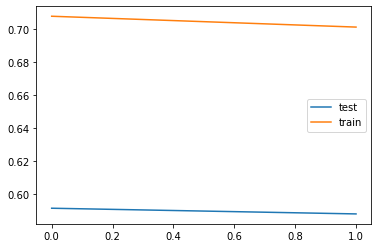

In [ ]:
test_scores = grid_search.cv_results_['mean_test_score']
train_scores = grid_search.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

### Model Evaluation train and test

In [ ]:
y_hat_train = grid_search.best_estimator_.predict(X_train)
y_hat = grid_search.best_estimator_.predict(X_test)

mae_train = metrics.mean_absolute_error(y_train, y_hat_train)
mae_test = metrics.mean_absolute_error(y_test, y_hat)

mse_train = metrics.mean_squared_error(y_train, y_hat_train)
mse_test = metrics.mean_squared_error(y_test, y_hat)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = metrics.r2_score(y_train, y_hat_train)
r2_test = metrics.r2_score(y_test, y_hat)

print(f'MAE train: {mae_train}')
print(f'MSE train: {mae_train}')
print(f'RMSE train: {rmse_train}')
print(f'R2 train: {r2_train}')

print()
print(f'MAE test: {mae_test}')
print(f'MSE test: {mae_test}')
print(f'RMSE test: {rmse_test}')
print(f'R2 test: {r2_test}')

MAE train: 1.0671428194377472
MSE train: 1.0671428194377472
RMSE train: 1.8091003900246236
R2 train: 0.7041522594609182

MAE test: 1.1658873878526435
MSE test: 1.1658873878526435
RMSE test: 2.1357232750866895
R2 test: 0.6160229151966642


## Make predictions

In [ ]:
submission = submission_sample.ID.str.split("_",expand=True)
submission.rename(columns={0: 'DATE', 1: 'S100', 2: 'I100', 3: 'C100', 4:'C101'}, inplace=True)

submission['DATE'] = pd.to_datetime(submission['DATE'])
submission['YEAR'] = submission['DATE'].dt.year
submission['MONTH'] = submission['DATE'].dt.month
submission['DAY'] = submission['DATE'].dt.day
submission = submission[['YEAR','MONTH','DAY','S100','I100','C100','C101']]

submission = submission.astype('float32')

submission_dummy=pd.merge(meta_item, submission, how='right', on='I100')
submission_full=pd.merge(meta_store, submission_dummy, how='right', on='S100')
submission_full.head()

submission = submission_full[['YEAR','MONTH','DAY','S100','S101','S102','S103','I100','I101','I102','I103','C100','C101']]

# submission = submission.astype('float32')

# y_hats = model.predict(submission)

y_hats = grid_search.best_estimator_.predict(submission)
 
submission_csv = submission_sample.copy()
submission_csv['QTT_PREDICTS'] = y_hats
submission_csv = submission_csv.drop('QTT', axis=1)
submission_csv = submission_csv.rename(columns={'QTT_PREDICTS': 'QTT'})

submission_csv.to_csv("data-h-m1-challenge-final-submission.csv",
                      encoding='utf-8', 
                      index=False)

submission_csv.to_csv("/content/gdrive/My Drive/Colab Notebooks/forecasting/data-h-m1-challenge-final/data-h-m1-challenge-final-submission.csv",
                      encoding='utf-8', 
                      index=False)

print()
print()
print('CSV saved successfully!!!')



CSV saved successfully!!!


## Kaggle competition submit

In [ ]:
!kaggle competitions submit -c data-h-m1-challenge-final -f data-h-m1-challenge-final-submission.csv -m "data-h-m1-challenge-final-submission"